# Credit Card Default Prediction Project

Based on the dataset UCI Machine Learning Repository

The original paper that works with this dataset is : Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.

* __[Link to original paper](https://bradzzz.gitbooks.io/ga-seattle-dsi/content/dsi/dsi_05_classification_databases/2.1-lesson/assets/datasets/DefaultCreditCardClients_yeh_2009.pdf)__

* __[Link to UCI dataset page](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)__

### Dataset Description
* Data consists of 30 000 points and 24 attributes

### Project Outline
Data preparation and exploration -> ML models hyperparameters tuning -> Combination into a final model

## Import : Data and Libraries
### Library Imports

In [9]:
# Imports
%matplotlib inline
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import scipy.cluster.hierarchy as sch
sns.set_style("dark")
sns.set_context("paper")

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.pipeline import Pipeline
from sklearn import metrics, preprocessing
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours

from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

%run EvalModel_file.ipynb
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


### Import and pre-processing of dataset 
(preprocessing : transforming data into ML model readable format)

In [10]:
# data imports

### EDIT FILEPATH IF NECESSARY
root = '.'
data_dir = '/DataFiles/'

# form filepaths
data_path = root + data_dir
train_file = data_path + 'CreditCard_train.csv'
test_file = data_path + 'CreditCard_test.csv'

# load
_df_train = pd.read_csv(train_file, index_col=0, header=1).rename(columns={'PAY_0':'PAY_1', 'default payment next month':'DEFAULT'})
_df_test = pd.read_csv(test_file, index_col=0, header=1).rename(columns={'PAY_0':'PAY_1', 'default payment next month':'DEFAULT'})

# create copy df for handling
df_train = _df_train.copy()
df_test = _df_test.copy()

### Data Checking

In [11]:
df_train.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
count,24000.000000,24000.000000,24000.000000,24000.00000,24000.000000,24000.000000,24000.00000,24000.000000,24000.000000,24000.000000,...,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.00000,24000.000000,24000.000000,24000.000000,24000.000000
mean,165495.986667,1.628250,1.847417,1.55725,35.380458,-0.003125,-0.12350,-0.154750,-0.211667,-0.252917,...,42368.188417,40000.682542,38563.710625,5542.912917,5.815336e+03,4969.26600,4743.480042,4783.486042,5189.399042,0.223750
std,129128.744855,0.483282,0.780007,0.52208,9.271050,1.123425,1.20058,1.204033,1.166549,1.136993,...,63070.680934,60345.012766,59155.759799,15068.576072,2.079703e+04,16095.61434,14883.269990,15270.405279,17630.371990,0.416765
min,10000.000000,1.000000,0.000000,0.00000,21.000000,-2.000000,-2.00000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.00000,28.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,...,2340.000000,1740.000000,1234.750000,1000.000000,8.000000e+02,379.00000,279.750000,244.000000,60.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.00000,34.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,18940.500000,18107.500000,17036.000000,2100.000000,2.000000e+03,1702.50000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.00000,41.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,52188.500000,49746.500000,48796.250000,5000.000000,5.000000e+03,4347.25000,4000.000000,4005.000000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.00000,79.000000,8.000000,8.00000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,505000.000000,1.684259e+06,896040.00000,497000.000000,417990.000000,528666.000000,1.000000


In [12]:
features = list(df_train.columns)[:-1]

# renaming columns for consistency and simplicity
df_train = df_train.rename(columns={'PAY_0':'PAY_1', 'default payment next month':'DEFAULT'})
df_test = df_test.rename(columns={'PAY_0':'PAY_1', 'default payment next month':'DEFAULT'})
label = df_train.columns[-1]

y_train = df_train[label]
X_train = df_train[features]

y_test = df_test[label]
X_test = df_test[features]


__Comment__ : All the data types are integers and thus workable for ML models. There are no null values (arbitrarily checked and all features have the same count). Values in the `SEX`, `EDUCATION` <br>
Optional to check and explore the data further into .DataExploration.

## Data Pipeline
* includes scaling, sampling and (future work : feature transformation)

In [13]:
from imblearn.over_sampling import SMOTE

# X_train_, y_train_ = SMOTE(random_state=3).fit_resample(X=X_train, y=y_train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
from sklearn.model_selection import train_test_split
X_train_, X_validation, y_train_, y_validation = train_test_split(X_train, y_train, test_size = 0.25, random_state = 0)



### Benchmarking some standard ML models

Checking the ML models
* xgboost, adaboost, gradientboostingregressor, logistic regression and support vector machines


## Hyperparameter tuning of ML models

Hyperparameter tuning framework consists of a tuner (hyperopt), optimization space (model dependent), and objective function (model  dependent)
These are imported.
### ML models to be optimized


In [15]:
# Optimizer
from hyperopt import Trials, fmin, tpe

# Model hyperparameter space
from Models_spaces import space_xgb, space_ada, space_gbrt, space_log, space_svm

# Model objective function
from Models_objectives import objective_xgb, objective_ada, objective_gbrt, objective_log, objective_svm


Saving data in a pickle file and opened again in model objectives. (not sure if I can include them as input to the objectives of each model, for version 2..)

In [16]:
import pickle

with open('objs.pkl', 'wb') as f:
    pickle.dump([X_train_, y_train_, X_validation, y_validation], f)
f.close()

### Tuning

For tuning we will be first split up the training data into a validation



short_run functionality, to check the script we can have the variable `short_run=True`

In [17]:
short_run = True

if short_run:
    max_evals = 1
else:
    max_evals = 50

In [18]:


trials = Trials()

best_hyperparams = fmin(fn = objective_xgb,
                        space = space_xgb,
                        algo = tpe.suggest,
                        max_evals = short_run,
                        trials = trials)


print("The best hyperparameters are : ","\n")
print(best_hyperparams)



SCORE:                                                  
0.8055                                                  
100%|██████████| 1/True [00:00<00:00,  1.03trial/s, best loss: -0.8055]
The best hyperparameters are :  

{'colsample_bytree': 0.6682461109723311, 'gamma': 3.083952984010085, 'learning_rate': 0.31630346169490353, 'max_depth': 9.0, 'min_child_weight': 7.0, 'reg_alpha': 169.0, 'reg_lambda': 0.709172999269214}


[01:01:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Confusion Matrix on the fitting data for model : XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9267151796260045,
             gamma=1.01854676464289, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=18, min_child_weight=9, missing=nan,
             monotone_constraints='()', n_estimators=180, n_jobs=8,
             num_parallel_tree=1, random_state=0, reg_alpha=61.0,
             reg_lambda=0.583387, scale_pos_weight=1, silent=False,
             subsample=0.8, tree_method='exa

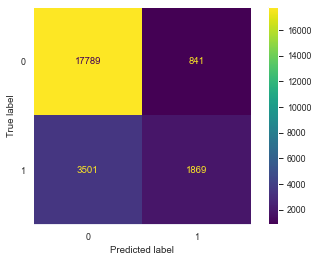

In [19]:
# still to be changed to similar to following models
xgb_reg = xgb.XGBRegressor(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.05,  
                      colsample_bytree = 0.9267151796260045,
                      min_child_weight = 9,
                      reg_lambda = 0.583387,
                      subsample = 0.8,
                      objective='reg:squarederror', 
                      n_estimators=180, 
                      reg_alpha = 61.0,
                      max_depth=18, 
                      gamma=1.01854676464289)

xgb_reg = fit_Model(xgb_reg, X_train, y_train,verbose=True, confusion_matrix=True)

In [20]:

from sklearn.metrics import accuracy_score
trials = Trials()

best_hyperparams = fmin(fn = objective_gbrt,
                        space = space_gbrt,
                        algo = tpe.suggest,
                        max_evals = short_run,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)



SCORE:                                                  
0.775                                                   
100%|██████████| 1/True [00:44<00:00, 44.87s/trial, best loss: -0.775]
The best hyperparameters are :  

{'learning_rate': 0.30610955548608226, 'loss': 2, 'max_depth': 12.0}


Confusion Matrix on the fitting data for model : GradientBoostingRegressor(learning_rate=0.30610955548608226, loss='huber',
                          max_depth=12.0) 


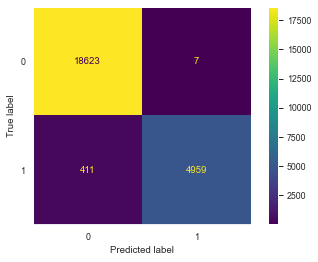

In [21]:
gbrt_loss_functions = ['ls', 'lad', 'huber', 'quantile']

gbrt_reg = GradientBoostingRegressor(
        max_depth = best_hyperparams['max_depth'],
        learning_rate=best_hyperparams['learning_rate'],
        loss = gbrt_loss_functions[best_hyperparams['loss']])

gbrt_reg = fit_Model(gbrt_reg, X_train, y_train,verbose=True, confusion_matrix=True)

In [22]:

trials = Trials()

best_hyperparams = fmin(fn = objective_ada,
                        space = space_ada,
                        algo = tpe.suggest,
                        max_evals = short_run,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)


SCORE:                                                  
0.8156666666666667                                      
100%|██████████| 1/True [00:11<00:00, 11.08s/trial, best loss: -0.8156666666666667]
The best hyperparameters are :  

{'learning_rate': 0.029611740504324826, 'loss': 2}


Confusion Matrix on the fitting data for model : AdaBoostRegressor(learning_rate=0.029611740504324826, loss='exponential') 


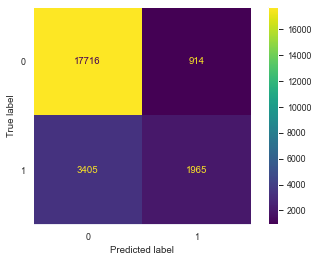

In [23]:
ada_loss_functions = ['linear', 'square', 'exponential']

ada_reg = AdaBoostRegressor(loss = ada_loss_functions[best_hyperparams['loss']], # this value referenced is the index of space_ada with key 'loss'
        learning_rate=best_hyperparams['learning_rate'])

ada_reg = fit_Model(ada_reg, X_train, y_train,verbose=True, confusion_matrix=True)



In [24]:
trials = Trials()

best_hyperparams = fmin(fn = objective_log,
                        space = space_log,
                        algo = tpe.suggest,
                        max_evals = short_run,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)


SCORE:                                                  
0.8096666666666666                                      
100%|██████████| 1/True [00:02<00:00,  2.18s/trial, best loss: -0.8096666666666666]
The best hyperparameters are :  

{'C': 0.19759011628621023, 'penalty': 0, 'solver': 1}


/Users/Jurren/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "



/Users/Jurren/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Confusion Matrix on the fitting data for model : LogisticRegression(C=0.19759011628621023, penalty='l1', solver='saga') 


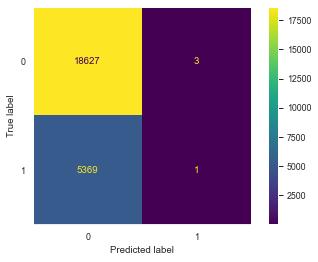

In [25]:
log_penalties = ['l1', 'l2', 'elasticnet']
log_solvers = ['liblinear', 'saga']

log_reg = LogisticRegression(C=best_hyperparams['C'],
                            penalty=log_penalties[best_hyperparams['penalty']],
                            solver=log_solvers[best_hyperparams['solver']])

log_reg = fit_Model(log_reg, X_train, y_train,verbose=True, confusion_matrix=True)

In [26]:
trials = Trials()

best_hyperparams = fmin(fn = objective_svm,
                        space = space_svm,
                        algo = tpe.suggest,
                        max_evals = short_run,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

SCORE:                                                  
0.7903333333333333                                      
100%|██████████| 1/True [00:29<00:00, 29.46s/trial, best loss: -0.7903333333333333]
The best hyperparameters are :  

{'C': 0.08162830773549691, 'degree': 1, 'kernel': 0}


In [30]:
%run EvalModel_file.ipynb

In [ ]:
svm_kernel = ['poly', 'rbf']
svm_degree = ['2','3','4']

if best_hyperparams =='poly':
    svm_reg = SVC(C=0.6959354436457543,
              kernel=svm_kernel[best_hyperparams['kernel']],
                  degree = svm_degree[best_hyperparams['degree']]
               )
else: 
    svm_reg = SVC(C=0.6959354436457543,
              kernel=svm_kernel[best_hyperparams['kernel']])

svm_reg = fit_Model(svm_reg, X_train, y_train,eval_metrics=True, confusion_matrix=True)




The hyperparameter optimization gives the models:

`xgb_reg`, `ada_reg`, `gbrt_reg`, `log_reg`, and `svm_reg`

Now we can test these models on the test set. Followed by checking each prediction's 'strenght' by using the Smooth Sorting Method as proposed in the original paper by Yeh and Lien.

In [ ]:
models = [xgb_reg, ada_reg, gbrt_reg, log_reg, svm_reg]
for model in models:
    y_predicted = model.predict(X_test)
    EvalMetrics(model, y_test, y_predicted, verbose = True, confusion_matrix = True)


## Performance at given percentages
### robustness

As opposed to simply classifiying clients as expected to default vs not-expected to default, quantifying is more meaningful. I.e. defining a probability of default has more potential.

To estimate the real probability, the Smooth Sorting Method can be used, which estimates the real probability by looking at neighboring points and taking the mean of these values.

__Smooth Sorting Method__ from the original paper (Yeh, I. C., & Lien, C. H. (2009)): 

$$\text{P}_i = \frac{\sum_{j=-n}^{n}\text{Y}_{i-j}}{2n+1}$$

where $\text{P}_i$ is the estimated real probability of default, $\text{Y}_{i}$ is the binary variable of default (1) or non-default (0), $n$ is the number of data for smoothing.<br>
The Smooth Sorting Method is used on sorted data, from the lowest probability of default occuring to the highest probability of default occuring. 

This is interesting to look at because loaners adopt different risk strategies.    
(for this we 

we have the lists : `y_predicted` and `y_test`

In [ ]:
xgb_reg = xgboost.XGBRegressor(eta=0.3, gamma=0.5, use_label_encoder=False)
xgb_reg.fit(X_train,y_train)
y_predicted = xgb_reg.predict(X_test)

In [ ]:
y_predicted

In [ ]:
sorted_index = np.argsort(y_predicted)

y_test_sorted = y_test_numpy[sorted_index]

In [ ]:
y_test_sorted

In [ ]:
y_avg = []
n = 200
for counter in range(n,len(y_test_sorted)-n):
    intermediate_val = np.mean(y_test_sorted[counter-n:counter+n])
    y_avg.append(intermediate_val)
    
y_predicted_sorted = sorted(y_predicted[n:len(y_predicted)-n])

In [ ]:
plt.plot(y_avg)
plt.show()

In [ ]:
plt.plot(sorted(y_predicted[n:len(y_predicted)-n]),y_avg)
plt.grid(True)
plt.ylim([0,1])
plt.show()

In [ ]:
np.shape(y_predicted[n:len(y_predicted)-n])

In [ ]:
sorted(y_predicted)

In [ ]:
n

In [ ]:
y_predicted_selected = y_predicted[n:len(y_predicted)-n]

In [ ]:
from sklearn.metrics import r2_score
print(r2_score(y_avg,y_predicted_selected))

In [ ]:
len(y_predicted)-n

